In [240]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#show plots with notebook itself
%matplotlib inline

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


#linear regression and mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from pandas import to_datetime


import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')



### Problem Formulation 
We want to forecast the GDP per Capita per country for the next 6 years 

### Load data from csv

In [241]:
raw_data = pd.read_csv("C:\\Users\\modx\\Desktop\\TimeSeriesForecastGDPRAW.csv.txt", encoding='latin-1')

#rows and columns
print(raw_data.shape)

raw_data.head()

(270038, 8)


,demo,indicator,location,country,time,value,flog codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN


### Data pre-processing

In [242]:
#check null values
raw_data.isnull().sum()

demo               0
indicator          0
location           0
country            0
time               0
value           2066
flog codes    267972
flags         267972
dtype: int64

In [243]:
#clean null values from values col

raw_data = raw_data.dropna(subset=['value'])

#remove last two columns with null values

raw_data= raw_data[['demo','indicator','location','country','time','value']]

raw_data.isnull().sum()


demo         0
indicator    0
location     0
country      0
time         0
value        0
dtype: int64

In [244]:
#checking unique values in each column

for column in raw_data:
    unique_value = np.unique(raw_data[column])
    unique_sum= len(unique_value)
    
    print('Unique value for feature {} : {}'.format(column,unique_sum))

Unique value for feature demo : 35
Unique value for feature indicator : 35
Unique value for feature location : 233
Unique value for feature country : 233
Unique value for feature time : 50
Unique value for feature value : 125438


In [245]:
#filtering out the data we need - GDP per Capita

forecast_data = raw_data[raw_data['indicator'] == 'GDP per capita, PPP (current international $)']


#filter out some countries

forecast_data = forecast_data[~forecast_data['country'].isin(['Djibouti', 'South Sudan', 'Curaþao', 'Eritrea', 'Bermuda', 'Venezuela (Bolivarian Republic of)'])]

forecast_data.head()




,demo,indicator,location,country,time,value
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89
76852,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81


In [246]:
#limiting columns we need 

forecast_data= forecast_data[['country','time','value']]
forecast_data.head()


,country,time,value
76848,Australia,1990,17333.10
76849,Australia,1991,17793.60
76850,Australia,1992,18189.34
76851,Australia,1993,19130.89
76852,Australia,1994,20063.81


In [247]:
#change the time to date as most time series models require data structure

# convert into string and upending -01-01
forecast_data['time'] = forecast_data['time'].astype(str) + '-01-01'

forecast_data['time'] = pd.to_datetime(forecast_data['time'])

forecast_data.head()



,country,time,value
76848,Australia,1990-01-01,17333.10
76849,Australia,1991-01-01,17793.60
76850,Australia,1992-01-01,18189.34
76851,Australia,1993-01-01,19130.89
76852,Australia,1994-01-01,20063.81


### Splitting the raw data for training and validation

In [248]:
x_train= forecast_data[forecast_data['time'] < '2012-01-01']
x_valid= forecast_data[forecast_data['time'] >= '2012-01-01']


print("X train shape: ",x_train.shape )
print("X validation shape: ",x_valid.shape )


X train shape:  (3967, 3)
X validation shape:  (1133, 3)


### ARIMA for dummies

https://medium.com/analytics-vidhya/arima-for-dummies-ba761d59a051

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


In [249]:
#running arima for USA

#filter the train data


us = x_train[x_train['country'] == 'United States of America']
us2 = us[['time', 'value']]

#filter valid data

us_v = x_valid[x_valid['country'] == 'United States of America']
us_v2 = us_v[['time', 'value']]


#set date to index -- need to do this to run time series model

us2.set_index('time', inplace=True)
us_v2.set_index('time', inplace=True)


# Setting the Index for 6 years going fwd-- use this as forecasting input later

#AS== annual frequency

index_6_years = pd.date_range(us2.index[-1], freq='AS', periods = 6) 




In [250]:
index_6_years

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

MSE of arima:  1857.434857766148


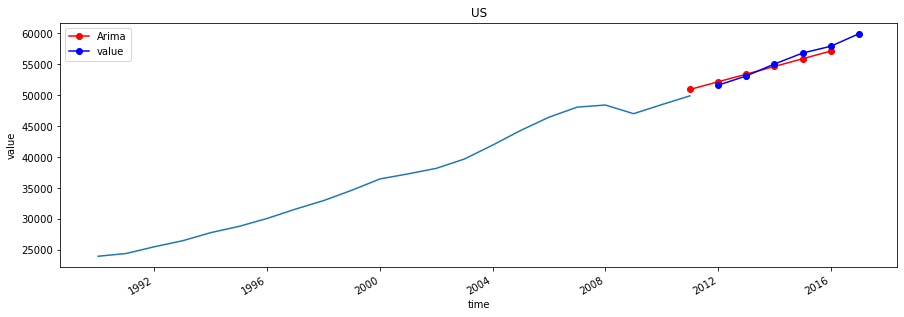

In [251]:
#running arima with random p,d,q


model_arima = ARIMA(us2, order=(0,2,2))  #random 3 values pdq
model_arima_fit= model_arima.fit(disp=-1)


#making predictions on the 6 year index without index first
fcast1= model_arima_fit.forecast(6)[0]
    
    
# Passing the index
fcast1 = pd.Series(fcast1, index=index_6_years)
fcast1 = fcast1.rename("Arima") 


# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data = us)
chart.set_title('US')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
us_v2.plot(ax=ax, color='blue', marker="o", legend=True)


#mean square error -- average squared difference between observed vs predicted
#tells us by how much $ our prediction is off by


print("MSE of arima: ",mean_squared_error(us_v['value'].values, fcast1.values, squared=False))


In [252]:
#Finding the best value for ARIMA

import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(us2,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better



(0, 0, 0) 465.3549075074627
(0, 0, 1) 442.10325523396943
(0, 0, 2) 421.15029296084674
(0, 0, 3) 407.33876146108014
(0, 1, 0) 343.4737347376556
(0, 1, 1) 341.8255733948989
(0, 1, 2) 343.8247813639084
(0, 1, 3) nan
(0, 1, 4) nan
(0, 2, 0) 332.60682979101045
(0, 2, 1) 333.3286321675839
(0, 2, 2) 331.1382243987239
(0, 2, 3) nan
(0, 2, 4) nan
(1, 0, 0) 393.35079861504573
(1, 1, 0) 342.667077800864
(1, 2, 0) 334.28219068893816
(2, 0, 0) 376.1853832804411
(2, 1, 0) 343.2633080441793
(2, 2, 0) 334.636537383821
(3, 0, 0) 378.4839332935119
(3, 1, 0) 343.4374648739158
(3, 2, 0) 335.91689073166094
(4, 0, 0) 380.31885532622584
(4, 1, 0) 361.09380760733205
(4, 2, 0) 336.0632858880646


### Running ARIMA for future predictions

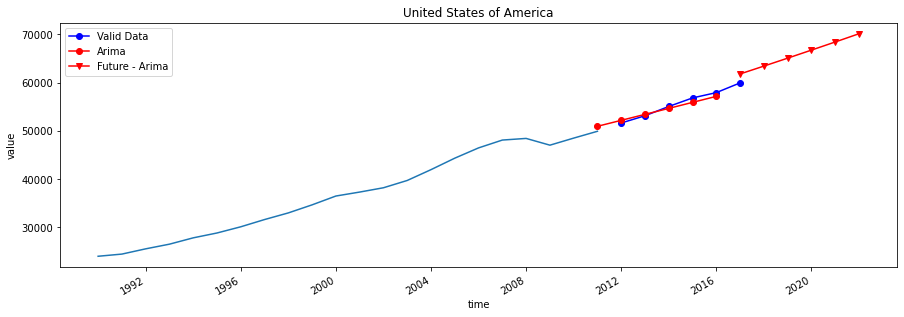

In [257]:
# creating a country list
countries = forecast_data['country'].unique()

countries = ['United States of America']


for c in countries:
    # filtering the train data - USA
    train_data =  x_train[x_train['country'] == c] 
    train_data2 = train_data[['time', 'value']] 
    
    # filtering the valid data  - USA
    valid_data = x_valid[x_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data  - USA
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    
    #convert date column to datetime for train and valid and all data
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    #rename -- need to see this
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_6_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 6) 
    
    # Setting the Future - Index for 6 years
    future_index_6_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 6) 
    
    
    # Dropping all tables for checking for other countries -- when in loop
    try:
        del t_fcast1
        
        
    except:
        print("")

   
        
        
        
        #########################################   ARIMA   ########################################
        
        #VALIDATION
        
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = ARIMA(train_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter 2
            model_arima = ARIMA(train_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    
    except:
            print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = ARIMA(all_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    
        except:
            # Running ARIMA on Best parameter 2
            model_arima = ARIMA(all_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 

        
    except:
            print(c, "Arima Future Error")   
            
            
            
            
            
            
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
  
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
   
    
